# Final Project: Fair Housing

### Chase Engelhardt

For the Final I have added some additonal outputs, working first (Part 1) with jobs/housing data to run a statistical autocorrelation, and then (part 2) doing an analysis on feasible housing units on public parcels in high and low opportunity Neighborhoods. 

# Part 1: Housing Jobs Imbalance Autocorrelation

# Import Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import fiona
import geopandas.geoseries  
import folium
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx
from shapely import wkt
import esda
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation
import libpysal as lps
import contextily as cx
import imageio

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


# Adding all years of cleaned housing/jobs data

In [2]:
# Import Data
jh2011=pd.read_csv('data/jh2011.csv')
jh2012=pd.read_csv('data/jh2012.csv')
jh2013=pd.read_csv('data/jh2013.csv')
jh2014=pd.read_csv('data/jh2014.csv')
jh2015=pd.read_csv('data/jh2015.csv')
jh2016=pd.read_csv('data/jh2016.csv')
jh2017=pd.read_csv('data/jh2017.csv')
jh2018=pd.read_csv('data/jh2018.csv')
jh2019=pd.read_csv('data/jh2019.csv')


In [3]:
# Make sure columns match
jh2019.rename(columns={'Number of Jobs Per Unit of Housing':'jobsperunithousing',
                       'Number of Jobs':'total_jobs_count',
                       'Units of Housing':'housing_units_count'},inplace=True)
jh2019['Year']='2019'
jh2013.head()


,Unnamed: 0,Neighborhood,geometry,geoid20,housing_units_count,OBJECTID,ShapeSTArea,ShapeSTLength,Year,total_jobs_count,jobsperunithousing
0,0,Adams-Normandie,"POLYGON ((-118.305408 34.025711999124255, -118...",66409439227,11696.0,8278.0,5.194088e+07,107582.924663,2013.0,1499.32,0.128191
1,1,Arleta,POLYGON ((-118.43578622489046 34.2298735046344...,84519667245,14411.0,2078.0,1.977866e+08,226887.739091,2013.0,2202.11,0.152808
2,2,Arlington Heights,POLYGON ((-118.33380900000002 34.0350109991241...,78483820162,15999.0,9240.0,7.472264e+07,137728.457729,2013.0,2508.86,0.156814
3,3,Atwater Village,POLYGON ((-118.27050800000009 34.1215079991231...,72447729825,18305.0,11452.0,3.720516e+08,286349.733482,2013.0,8028.72,0.438608
4,4,Baldwin Hills/Crenshaw,POLYGON ((-118.36503589102983 34.0055609073337...,126784467665,34478.0,24429.0,2.715788e+08,350832.124002,2013.0,6211.40,0.180155


In [4]:
# Create list of dataframes
jhlist1=[jh2011,
jh2012,
jh2013,
jh2014,
jh2015,
jh2016,
jh2017,
jh2018]

# change year to string for all dfs
for jh in jhlist1:
   
    jh['Year'] =  jh['Year'].astype(str)
    jh['Year'] =  jh['Year'].str.rstrip('.0')
    

In [5]:
# list including 2019
jhlist=[jh2011,
jh2012,
jh2013,
jh2014,
jh2015,
jh2016,
jh2017,
jh2018,
jh2019]



In [6]:
# Dropping null values (this is important for the autocorrelaion)
jh2011=jh2011.dropna()
jh2012=jh2012.dropna()
jh2013=jh2013.dropna()
jh2014=jh2014.dropna()
jh2015=jh2015.dropna()
jh2016=jh2016.dropna()
jh2017=jh2017.dropna()
jh2018=jh2018.dropna()
jh2019=jh2019.dropna()

In [7]:
# Defining function to convert to geodataframes
def addgeo(jh):
    jh['geometry'] = jh['geometry'].apply(wkt.loads)
    jh = gpd.GeoDataFrame(jh, crs="EPSG:4326",geometry='geometry')
    jh = jh.to_crs(3857)
    return jh
    

In [8]:
# running the function
jh2011=addgeo(jh2011)
jh2012=addgeo(jh2012)
jh2013=addgeo(jh2013)
jh2014=addgeo(jh2014)
jh2015=addgeo(jh2015)
jh2016=addgeo(jh2016)
jh2017=addgeo(jh2017)
jh2018=addgeo(jh2018)
jh2019=addgeo(jh2019)

/tmp/ipykernel_1895/3297003038.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jh['geometry'] = jh['geometry'].apply(wkt.loads)


In [9]:
# creating a dictionary of dataframes to run through the final function later
jhdict={0:jh2011,
1:jh2012,
2:jh2013,
3:jh2014,
4:jh2015,
5:jh2016,
6:jh2017,
7:jh2018,
8:jh2019}

<AxesSubplot: >

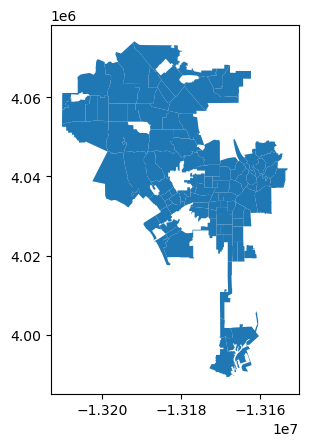

In [10]:
# confirming that the dfs successfully added geometries
jh2011.plot()

In [11]:
 # creating lists for gif function below 
frames = []
time=[0,1,2,3,4,5,6,7,8]

# Autocorrelation Function

In [12]:
def autocorrelate(key,jh=jh2011):
# calculate spatial weight
    wq =  lps.weights.KNN.from_dataframe(jh,k=8)

    # Row-standardization
    wq.transform = 'r'

    # create a new column for the spatial lag
    jh['Number_jobs_div_Housing_Lag'] = lps.weights.lag_spatial(wq, jh['jobsperunithousing'])

    # create a column that calculates the difference between arrests and lag
    jh['JH_lag_diff'] = jh['jobsperunithousing'] - jh['Number_jobs_div_Housing_Lag']
  
    # output to get the head and tail
    jh.sort_values(by='JH_lag_diff')
    
    jh.set_index
    y = jh['Number_jobs_div_Housing_Lag']
    moran = Moran(y, wq)
    moran.I
    
    moran.p_sim
   
    lisa = esda.moran.Moran_Local(y, wq)
    
    # create the 1x2 subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 12))

# regular count map on the left
    lisa_cluster(lisa, jh, p=0.05, ax=ax[0])

    ax[0].axis("off")
    ax[0].set_title('Housing/Jobs Imbalance Autocorrelation'+':'+jh['Year'].iloc[0]+', '+'P-value: 0.05')

# spatial lag map on the right
    lisa_cluster(lisa, jh, p=0.01, ax=ax[1])
    ax[1].axis("off")
    ax[1].set_title("Housing/Jobs Imbalance Autocorrelation"+":"+jh['Year'].iloc[0]+', '+"P-value: 0.01")
    cx.add_basemap(ax[0],source=cx.providers.CartoDB.Positron)
    cx.add_basemap(ax[1],source=cx.providers.CartoDB.Positron)

   
    plt.savefig(f'./autoc{key}.png')    
    plt.close()
    
  

In [13]:
# Runs my dictionary of dataframes through my function and saves the outputs as static images
for key,v in jhdict.items(): 
    autocorrelate(key,v)

# Making a GIF

In [14]:
# appends the images to a list 
for t in time:
    image = imageio.v2.imread(f'autoc{t}.png')
    frames.append(image)
# tells imageio to take that list and turn it into a gif   
imageio.mimsave('HJAutocorrelation.gif', # output gif
                frames,          # array of input frames
                fps = 1)         # optional: frames per second

# Function For a Single Output With Neighborhood Lines



## Add Neighborhood Lines

<AxesSubplot: >

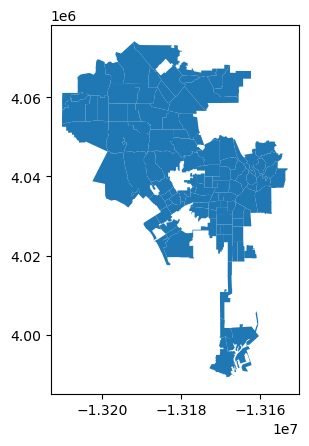

In [15]:
# Create Neighborhoods Layer

    
#Import neighborhood shapes
url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
nhoods=gpd.read_file(url,crs='EPSG:4326')
nhoods=nhoods.to_crs('EPSG:3857')
# rename neighborhood column, set index
nhoods=nhoods.rename(columns={'name':'Neighborhood'})
#drop shapes not in city of LA
nhoods.drop(nhoods[nhoods['type'] != 'segment-of-a-city'].index, inplace = True)

nhoods.plot()

## Updated Function

In [16]:
def autocorrelate1(jh=jh2011):
# calculate spatial weight
    wq =  lps.weights.KNN.from_dataframe(jh,k=8)

    # Row-standardization
    wq.transform = 'r'

    # create a new column for the spatial lag
    jh['Number_jobs_div_Housing_Lag'] = lps.weights.lag_spatial(wq, jh['jobsperunithousing'])

    # create a column that calculates the difference between arrests and lag
    jh['JH_lag_diff'] = jh['jobsperunithousing'] - jh['Number_jobs_div_Housing_Lag']
  
    # output to get the head and tail
    jh.sort_values(by='JH_lag_diff')
    
    jh.set_index
    y = jh['Number_jobs_div_Housing_Lag']
    moran = Moran(y, wq)
    moran.I
    
    moran.p_sim
   
    lisa = esda.moran.Moran_Local(y, wq)
    
    # create the 1x2 subplots
    fig, ax = plt.subplots(1, figsize=(10, 12))
    

# Lisa Cluster Layer
    lisa_cluster(lisa, jh, p=0.05, ax=ax)
    
    # Neighborhood Lines Layer
    nhoods.plot(
            ax=ax,
            color='none',
            edgecolor = 'white',
            linewidth = 0.5,)

    ax.axis("off")
    ax.set_title('Housing/Jobs Imbalance Autocorrelation'+':'+jh['Year'].iloc[0]+', '+'P-value: 0.05')
    

   
    
    cx.add_basemap(ax,source=cx.providers.CartoDB.Positron)

    plt.savefig('HousingJobsAutoc2019.png',bbox_inches='tight')
    
  

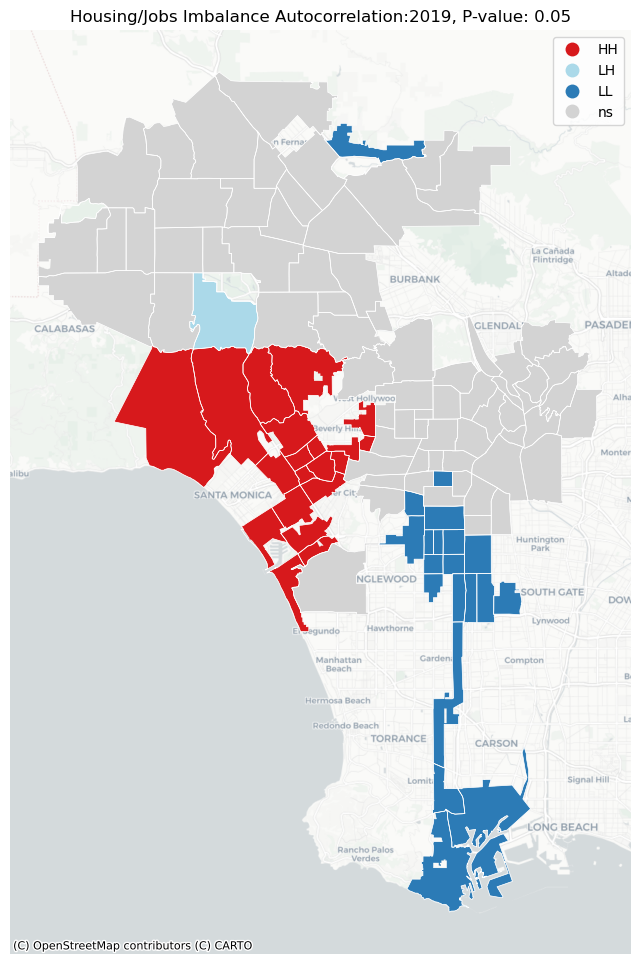

In [17]:
autocorrelate1(jh2019)



# Part 2: Working with data on available public land 

This is to show the shortcomings of relying exclusively on public land to affirmatively further fair housing. The analyis finds a great disparity in the overal number of feasible units between high and low opportunity neighborhoods

# Import and clean Data

In [2]:
# import data
vacant=pd.read_csv('data/City-Owned_Property.csv')
vacant.sample(15)
vacant.Property_C.unique()

array(['Vacant Land', 'Residential Improved', 'Commercial Improved',
       'Public Facility', 'Commercial Vacant Land',
       'Residential Vacant Land', 'OPLA', 'Parking Facility',
       'Maintenance Yard', 'Park', 'Not Classified',
       'Public Safety Facility', 'Street Median', 'Open Space',
       'Industrial Improved', 'Industrial Vacant Land', 'Under Review'],
      dtype=object)

In [3]:
#filter Data
typelist=['Vacant Land',
        'Commercial Vacant Land',
       'Residential Vacant Land', 'Parking Facility', 'Industrial Vacant Land']

## Removing public land that can't be developed (e.g. Street Meridian)

In [4]:
filtered= vacant[vacant.Property_C.isin(typelist)]

filtered.Property_C.unique()

array(['Vacant Land', 'Commercial Vacant Land', 'Residential Vacant Land',
       'Parking Facility', 'Industrial Vacant Land'], dtype=object)

In [5]:
# Create GDF
vacgdf = geopandas.GeoDataFrame(filtered, geometry=geopandas.points_from_xy(filtered['X'], filtered['Y'],crs="EPSG:4326"))
vacgdf.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 584 entries, 0 to 1809
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   X           584 non-null    float64 
 1   Y           584 non-null    float64 
 2   OBJECTID    584 non-null    int64   
 3   FID_        584 non-null    int64   
 4   Parcel_Num  584 non-null    int64   
 5   Property_C  584 non-null    object  
 6   Property_S  584 non-null    object  
 7   Inventory   584 non-null    object  
 8   Zoned_As    584 non-null    object  
 9   Address1    584 non-null    object  
 10  County      584 non-null    object  
 11  City        584 non-null    object  
 12  Longitude   584 non-null    float64 
 13  Latitude    584 non-null    float64 
 14  Council_Di  584 non-null    int64   
 15  Square_Foo  584 non-null    float64 
 16  Business_I  584 non-null    object  
 17  geometry    584 non-null    geometry
dtypes: float64(5), geometry(1), int64(4), obj

## Adding Columns to Dataframe for Assumptions
We're going to be generous and assume a density of 4x what is allowed in most transit neighborhood plans in the City of Los Angeles (i.e. 1 unit per 100sqft) due to the fact that these are public parcels and the city will likely want to maximize investment per unit. However, in order for projects to properly amortize, they need to have a reasonable amount of units. What is actually feasible depends on myriad conditions, but we will use 50 units as the minimum threshold for a public project.

In [6]:

filtered['Theoretical buildable Lot Size']=vacgdf['Square_Foo']*.25
vacgdf['TheoreticalUnits']= (vacgdf['Theoretical buildable Lot Size']/400)*4
punits=df = vacgdf[vacgdf.TheoreticalUnits> 50]
punits.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 102 entries, 5 to 1799
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   X                               102 non-null    float64 
 1   Y                               102 non-null    float64 
 2   OBJECTID                        102 non-null    int64   
 3   FID_                            102 non-null    int64   
 4   Parcel_Num                      102 non-null    int64   
 5   Property_C                      102 non-null    object  
 6   Property_S                      102 non-null    object  
 7   Inventory                       102 non-null    object  
 8   Zoned_As                        102 non-null    object  
 9   Address1                        102 non-null    object  
 10  County                          102 non-null    object  
 11  City                            102 non-null    object  
 12  Longitude    

/tmp/ipykernel_1702/2884691759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['Theoretical buildable Lot Size']=vacgdf['Square_Foo']*.25


<AxesSubplot: >

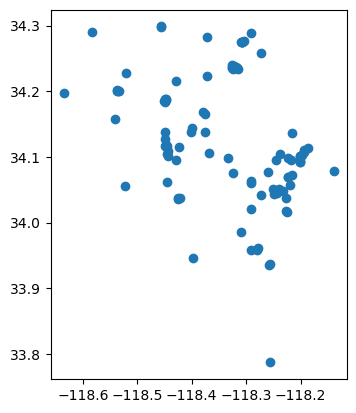

In [7]:
punits.plot()

# Import wildfire zones to remove points in high wildfire areas

<AxesSubplot: >

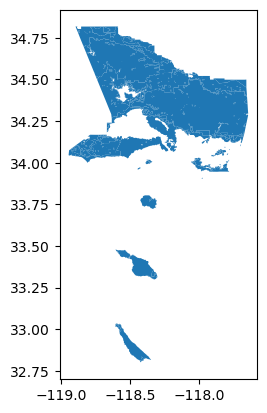

In [8]:
fire=geopandas.read_file('data/Fire_Hazard_Severity_Zones.shp',crs='EPSG:4326')
fire.plot()

<AxesSubplot: >

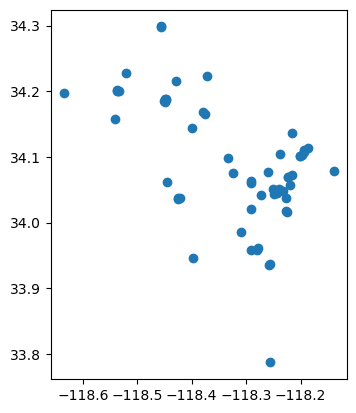

In [9]:
# remove points in Wildfire zones 
punits = punits.overlay(fire, how='difference')
punits.plot()

### Results 

We can see that the number of viable parcels has decreased substaintially. 

# High Opportunity Neighborhoods and Affordable Housing


In [10]:
def nhdissolve(df,geometry,math,skip=False):
    
    #Import neighborhood shapes
    url = "https://usc.data.socrata.com/api/geospatial/r8qd-yxsr?method=export&format=GeoJSON"
    nhoods=gpd.read_file(url)
   
    #This is to make the geography column recognizable, toggling skip to True allows you to avoid an error message if your geometry column does not need this operation
    runwkts=skip
    if runwkts==False:
        df[geometry] = df[geometry].apply(wkt.loads)
    #add a CRS
    gdf = gpd.GeoDataFrame(df, crs="EPSG:4326",geometry='geometry')
     #join race with nh shapes, rename neighborhood column, and set it as the index
    nhjoin=gdf.overlay(nhoods, how='intersection')
    nhjoin=nhjoin.rename(columns={'name':'Neighborhood'})
    nhjoin.set_index('Neighborhood',inplace=True)
    
    #drop shapes not in city of LA
    nhjoin.drop(nhjoin[nhjoin['type'] != 'segment-of-a-city'].index, inplace = True)

    #approximate average for data in neighborhoods 
    nhdata= nhjoin.dissolve(by='Neighborhood', aggfunc= math)
    nhdata.head()
    return nhdata
    

In [11]:
# import data to run neighborhood function
opmap=pd.read_csv('data/opportunity.csv')
#add numeric values based on opportunity category 
opmap['Opportunity Number'] = opmap['oppcat']
opmap['Opportunity Number'] =opmap['Opportunity Number'].replace(['Highest Resource', 'High Resource','Moderate Resource','Low Resource','High Segregation & Poverty'], [1,2,3,4,5])


In [12]:
# run the dissolve function
opmapgdf= nhdissolve(df=opmap,geometry='geometry',math='mean',skip=False)
# re-associate the integer with the category
opmapgdf['Opportunity Number']=opmapgdf['Opportunity Number'].round()
opmapgdf['oppcat']=opmapgdf['Opportunity Number']
opmapgdf['oppcat'] =opmapgdf['oppcat'].replace([1,2,3,4,5],['Highest Resource', 'High Resource','Moderate Resource','Low Resource','High Segregation & Poverty'])


/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


In [13]:
# re-add color column
opmapgdf['color']=''
opmapgdf.loc[opmapgdf['oppcat'] == 'Highest Resource', 'color'] = '#93b9c6ff'
opmapgdf.loc[opmapgdf['oppcat'] == 'High Resource', 'color'] = '#aed0d9ff'
opmapgdf.loc[opmapgdf['oppcat'] == 'Moderate Resource', 'color'] = '#d4d4d4ff'
opmapgdf.loc[opmapgdf['oppcat'] == 'Low Resource', 'color'] = '#eec8d7ff'
opmapgdf.loc[opmapgdf['oppcat'] == 'High Segregation & Poverty', 'color'] = '#E487AD'
opmapgdf.sort_values(by=['Opportunity Number'], inplace=True)

In [14]:
colorlist=[ '#93b9c6ff', '#aed0d9ff','#d4d4d4ff','#eec8d7ff', '#E487AD']
opplist=['Highest Resource', 'High Resource', 'Moderate Resource',
       'Low Resource', 'High Segregation & Poverty']

In [15]:
colordict={'#93b9c6ff':'Highest Resource','#aed0d9ff': 'High Resource', '#d4d4d4ff':'Moderate Resource',
       '#eec8d7ff':'Low Resource', '#E487AD':'High Segregation & Poverty'}

In [16]:
punits['PossibleUnits']=round(punits.TheoreticalUnits)
punits.head()
punits['PossibleUnits']= punits['PossibleUnits'].map(str)
opmapgdf.reset_index(inplace=True)



In [17]:
punits.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   X                               60 non-null     float64 
 1   Y                               60 non-null     float64 
 2   OBJECTID                        60 non-null     int64   
 3   FID_                            60 non-null     int64   
 4   Parcel_Num                      60 non-null     int64   
 5   Property_C                      60 non-null     object  
 6   Property_S                      60 non-null     object  
 7   Inventory                       60 non-null     object  
 8   Zoned_As                        60 non-null     object  
 9   Address1                        60 non-null     object  
 10  County                          60 non-null     object  
 11  City                            60 non-null     object  
 12  Longitude       

In [18]:
punits = punits[punits.Address1!='9851 S SEPULVEDA BLVD']
punits.head()

,X,Y,OBJECTID,FID_,Parcel_Num,Property_C,Property_S,Inventory,Zoned_As,Address1,...,City,Longitude,Latitude,Council_Di,Square_Foo,Business_I,geometry,Theoretical buildable Lot Size,TheoreticalUnits,PossibleUnits
0,-118.257021,33.936149,6,0,6071021915,Vacant Land,Owned,EWDD,M1-1,10931 South Clovis Ave,...,LOS ANGELES,-118.257021,33.936149,8,185911.0000,,POINT (-118.25702 33.93615),46477.7500,464.777500,465.0
1,-118.291621,34.020931,9,0,5040030905,Commercial Vacant Land,Owned,EWDD,PF-1,3685 S Vermont AVE,...,Los Angeles,-118.291621,34.020931,8,33398.0000,,POINT (-118.29162 34.02093),8349.5000,83.495000,83.0
2,-118.249929,34.050811,10,0,5149010939,Commercial Vacant Land,Owned,EWDD,C2-4D,361 S HILL ST,...,LOS ANGELES,-118.249929,34.050810,14,104945.2540,,POINT (-118.24993 34.05081),26236.3135,262.363135,262.0
3,-118.541305,34.157272,20,0,2176026900,Vacant Land,Surplus-Undeclared,General Services,RA-1,18801 EDLEEN DR,...,LOS ANGELES,-118.541306,34.157272,3,21383.0608,None,POINT (-118.54131 34.15727),5345.7652,53.457652,53.0
4,-118.399633,34.143592,34,0,2367017017,Parking Facility,Leased,General Services,,12229 VENTURA BLVD,...,LOS ANGELES,-118.399633,34.143592,2,25710.4000,,POINT (-118.39963 34.14359),6427.6000,64.276000,64.0


## Interactive Map with Publicly Owned Vacant Land in those Neighborhoods

In [19]:

          


m = folium.Map(tiles='CartoDBPositron',location=[34.0522, -118.2437], zoom_start=10)

#Public Land
for index, row in punits.iterrows():
    tooltip_text ='Type:'+ row.Property_C +','+ ' Theoretical Units Possible:' + row.PossibleUnits
    folium.Marker(
        [row.Y,row.X], 
        popup=row.TheoreticalUnits, 
        tooltip=tooltip_text,
        icon=folium.Icon(color='beige')
    ).add_to(m)
#Opportunity Layer 
folium.Choropleth(
    geo_data=opmapgdf,
    name="Jobs Per Neighborhood",
    data=opmapgdf,
    columns=["Neighborhood","Opportunity Number"],
    key_on="feature.properties.Neighborhood",
    fill_color="PuRd",
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name="Opportunity Categories",
    show=True,

).add_to(m)
    

folium.LayerControl().add_to(m)

m

In [20]:
opmapgdf.head()

,Neighborhood,geometry,Unnamed: 0,OBJECTID,fips,Opportunity Number,oppcat,color
0,Sherman Oaks,"POLYGON ((-118.47611 34.12601, -118.47413 34.1...",406.000000,1.0,6.037183e+09,1.0,Highest Resource,#93b9c6ff
1,Mid-Wilshire,"POLYGON ((-118.35381 34.04821, -118.35681 34.0...",625.700000,1.0,6.037215e+09,1.0,Highest Resource,#93b9c6ff
2,Pacific Palisades,"MULTIPOLYGON (((-118.56710 34.04138, -118.5671...",779.294118,1.0,6.037348e+09,1.0,Highest Resource,#93b9c6ff
3,Hollywood Hills West,"POLYGON ((-118.38965 34.09106, -118.39192 34.0...",634.000000,1.0,6.037337e+09,1.0,Highest Resource,#93b9c6ff
4,Palms,"POLYGON ((-118.43030 34.02682, -118.42998 34.0...",904.272727,1.0,6.037310e+09,1.0,Highest Resource,#93b9c6ff


In [21]:
hopp = opmapgdf[opmapgdf['Opportunity Number']<3]
hopp.sample(15)
lopp=opmapgdf[opmapgdf['Opportunity Number']>2]
lopp.sample(10)
hopp.reset_index(inplace=True)
lopp.reset_index(inplace=True)

In [22]:
oppvac=punits.overlay(hopp, how='intersection')
loppvac=punits.overlay(lopp, how='intersection')

In [23]:
m2=hopp.explore(

        legend=True,
        color='#93b9c6ff', # the "_r" reverses the color
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        },
        tiles='CartoDBPositron',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        )
oppvac.explore(
    m=m2,
    legend=True,
        marker_kwds={'radius':7},
        style_kwds={
            'weight':0.5,
            'color':'black',
            'fillColor':'brown',
            'opacity':0.5
        },
        tiles='CartoDBPositron',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        
    )
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Possible Units: High Opportunity Nieghborhoods</b></h3>
             '''
m2.get_root().html.add_child(folium.Element(title_html))
m2.save("punitsHigh.html")

m2

In [24]:
m3=lopp.explore(

        legend=True,
        color='#E487AD',
        style_kwds={
            'weight':0.5,
            'color':'black',
            'opacity':0.5
        },
        tiles='CartoDBPositron',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        )
loppvac.explore(
    m=m3,
    legend=True,
        marker_kwds={'radius':7},
        style_kwds={
            'weight':0.5,
            'color':'black',
            'fillColor':'blue',
            'opacity':0.5
        },
        tiles='CartoDBPositron',
        attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        )

title_html1 = '''
             <h3 align="center" style="font-size:20px"><b>Possible Units: Low Opportunity Nieghborhoods</b></h3>
             '''
m3.get_root().html.add_child(folium.Element(title_html1))

m3


## Summary of units Possible Per Neighborhood

In [25]:
hv=oppvac.groupby(['Neighborhood'],)["TheoreticalUnits"].sum()
lv=loppvac.groupby(["Neighborhood"])["TheoreticalUnits"].sum()

hv=hv.to_frame()
lv=lv.to_frame()
hv['Opportunity']='High'
lv['Opportunity']='Low'
hv=hv.reset_index()

lv=lv.reset_index()
hvlv=hv.merge(lv,how='outer')
hvlv.sort_values(by='TheoreticalUnits',ascending=False)

,Neighborhood,TheoreticalUnits,Opportunity
16,Green Meadows,1550.801370,Low
12,Downtown,1039.779314,Low
19,Lincoln Heights,821.575148,Low
20,North Hollywood,558.975198,Low
26,Van Nuys,541.615346,Low
17,Highland Park,484.649475,Low
23,Reseda,355.161873,Low
11,Chesterfield Square,303.695000,Low
24,Sun Valley,271.074308,Low
3,Rancho Park,212.385193,High


In [26]:
from pathlib import Path  

filepath = Path('HighLowOpp.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

hvlv.to_csv(filepath)  

In [28]:



fig = px.histogram(hvlv, x="Opportunity", y="TheoreticalUnits", color="Opportunity",color_discrete_map = {'Low':'#E487AD','High':'#93B9C6'},
                  labels={'Opportunity':'High Or Low Opportunity Neighborhoods','TheoreticalUnits':'Possible Housing Units'}, height=450)

fig.update_layout(
    title='Possible Housing Units on Public Land in Los Angeles')

    

TypeError: histogram() got an unexpected keyword argument 'size'